## g:profiler enrichment analysis evaluation 

updated the gene name. 

1.  default setting pick the lowest p val when it pass both coverage and pval threshold as best term, then filter by coverage for both LLM and enrichment 
    
2. pick the smallest p val and remove the coverage requirment for both

    a. pick the smallest p, then add coverage requirement 

    b. pick the smallest p , then add JI requirement

3. pick best coverage among the ones passing both coverage and pval threshold, then filter by coverage 

4. use semantic similarity to find closest GO term as LLM name (in separate notebook), then use JI for picking best term and filtering 

    


In [46]:
LLM_score_thresh = 0.01 # only drop the ones LLM does not assign a name 
adj_pval_thresh = 0.05
JI_thresh = 0.05
coverage_thresh = 0.2

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7

from utils.analyze_enrichment_utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data files from other analyses:
 - inputfile: LLM analyzed + gProfiler enrichment analysis on updated gene symbols
 - LLM coverage analysis - used GPT-4 to review the analysis text to determine which genes met the criteria that they are "definite" supports, not conjecture.
 - Best matching GO terms to LLM names, used to estimate how many genes match the name, enabling the computation of a JI

In [48]:

import pandas as pd
from utils.analyze_enrichment_utils import cal_JI_coverage

group_col = ["Source", "GeneSetID", "GeneSetName", "GeneList"] # group by these columns in future steps

## input file: LLM analyzed + gProfiler enrichment
# updated_name_llm_file = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF.tsv'
updated_name_llm_file = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_trimed_name_simVals_DF.tsv'
# Read the TSV file into a Pandas DataFrame
LLM_genes_DF = pd.read_csv(updated_name_llm_file, delimiter="\t")
# make sure intersection_size, term_size, query_size are integers
LLM_genes_DF['intersection_size'] = LLM_genes_DF['intersection_size'].apply(lambda x: int(x))
LLM_genes_DF['term_size'] = LLM_genes_DF['term_size'].apply(lambda x: int(x))
LLM_genes_DF['query_size'] = LLM_genes_DF['query_size'].apply(lambda x: int(x))
#LLM_genes_DF.shape
LLM_genes_DF = cal_JI_coverage(LLM_genes_DF)
LLM_genes_DF.head(1)

,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,...,Adjusted P-value,intersection_size,term_size,query_size,intersections,trimed LLM Name,trimed Term,LLM_name_GO_term_sim,gprofiler_JI,gprofiler_coverage
0,NeST,Cluster1-10,Cluster1-10,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,12,Lipid Metabolism and Membrane Dynamics,"1. CTRL, or carboxyl-terminal esterase/lipase,...",0.85,L-leucine import across plasma membrane,...,0.080467,1,5,10,SLC7A8,lipid metabolism and membrane dynamics,l-leucine import across plasma membrane,0.288667,0.071429,0.1


In [49]:
## load the LLM coverage data as a common df to merge
llm_coverage_df = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals_new_genecounts_DF.tsv", sep="\t")[['Source','GeneSetID',
                'GeneSetName', 'GeneList', 'n_Genes', 
                'Supporting Genes','Supporting Count','LLM Support Analysis','GenesMentionedInText', 'LLM_coverage']]

llm_JI_file = 'data/omics_revamped_LLM_w_best_matching_GO_terms_for_JI.tsv'
llm_ji_df = pd.read_csv(llm_JI_file, sep="\t")

In [50]:
# merge with the LLM coverage data
merged_genes_DF = pd.merge(LLM_genes_DF, llm_coverage_df, on=['Source','GeneSetID','GeneSetName', 'GeneList', 'n_Genes'], how='left')
print(merged_genes_DF.shape)
# print(merged_genes_DF.columns)


# merge with the LLM JI data

merged_genes_DF = pd.merge(merged_genes_DF, llm_ji_df, on=['Source','GeneSetID','GeneList','n_Genes', 'LLM Name','Supporting Count'], how='left')
print(merged_genes_DF.shape)
print(merged_genes_DF.columns)

(53452, 26)
(53452, 31)
Index(['Source', 'GeneSetID', 'GeneSetName', 'GeneList', 'updated GeneList',
       'n_Genes', 'LLM Name', 'LLM Analysis', 'Score', 'Term', 'GO ID',
       'Adjusted P-value', 'intersection_size', 'term_size', 'query_size',
       'intersections', 'trimed LLM Name', 'trimed Term',
       'LLM_name_GO_term_sim', 'gprofiler_JI', 'gprofiler_coverage',
       'Supporting Genes', 'Supporting Count', 'LLM Support Analysis',
       'GenesMentionedInText', 'LLM_coverage', 'LLM_best_matching_GO',
       'best_matching_GO_ID', 'best_matching_GO_term_genes',
       'best_matching_GO_term_size', 'LLM_JI'],
      dtype='object')


# 1. Best APV that also passes coverage threshold

 - Select the best GO term by the smallest p-value among the terms passing the p-value and coverage threshold. 
 - Filter by both p-value and coverage threshold to determine success vs not. 

However, there may be multiple GO terms with the smallest p-value and this procedure returns the one that is first in the list. 

This means that in a significant number of cases, the selected GO term will *not* have the best coverage.

In [43]:
from utils.analyze_enrichment_utils import filter_and_select_coverage, create_success_contingency_table, select_rows_and_columns

input_df = merged_genes_DF.copy()

# Grouping the DataFrame by the specified columns
grouped = input_df.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_by_coverage_DF = grouped.apply(lambda x: filter_and_select_coverage(x, coverageCol = 'gprofiler_coverage', thresh = coverage_thresh, adj_pval_thresh=adj_pval_thresh)).reset_index(drop=True)

# reset LLM_success_TF and gprofiler_success_TF
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = False
reduced_LLM_genes_by_coverage_DF['gprofiler_success_TF'] = False

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_coverage_DF['Score'] >= LLM_score_thresh) & (reduced_LLM_genes_by_coverage_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_by_coverage_DF['gprofiler_success_TF'] = ((reduced_LLM_genes_by_coverage_DF['Adjusted P-value'] <= adj_pval_thresh) & (reduced_LLM_genes_by_coverage_DF['gprofiler_coverage'] >= coverage_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_coverage_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   103    113    216
False                    9     75     84
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,cellular catabolic process,GO:0044248,0.010811,8,1600,"S100A8,TWIST1,VIM,CLU,TENT5A,MAOB,SLC27A2,ZBTB20",0.363636,0.21,0.004957,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


In [36]:
# Save the DataFrame to a TSV file
reduced_LLM_genes_by_coverage_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_coverage_thresh.tsv", sep="\t", index=False)

Because we picked the best GO term by the smallest p-value among the terms passing the p-value and coverage threshold, it means that changing the coverage threshold will change the curve. 

This g:Profiler curve is based on GO terms picked by setting the coverage threshold at 0.2. If we pick a **different** threshold, then the curve will change

coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 216.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 76.0, LLM: 64.0


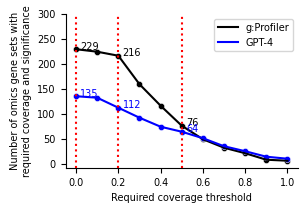

In [44]:
## plot coverage threshold curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2

save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_coverage_thresh_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_by_coverage_DF, 
                      'gprofiler_coverage', 
                      'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), 
                      enrich_adj_pval_thresh = adj_pval_thresh, 
                      LLM_score_thresh = LLM_score_thresh, 
                      highlight_coverage = [0.0, 0.2, 0.5])


# 2. Best APV

 - Select the best GO by the smallest p-value
 - Filter by p-value. 

If we later apply a coverage threshold to generate this curve, the curve will not change if the threshold is changed because the enriched term is not picked based on the coverage threshold

In [55]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

coverage_thresh = 0.2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_only_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_JI')).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_only_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_only_DF['Score'] >= LLM_score_thresh))
reduced_LLM_genes_APV_only_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_only_DF['Adjusted P-value'] > adj_pval_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_APV_only_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_only_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   124    105    229
False                   11     60     71
Total                  135    165    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,inflammatory response,GO:0006954,0.001123,11,829,"1060P11.3,ADM,CAV2,CDC42EP3,EMP1,LPAR6,TRIB2,A...",0.250000,0.13,0.012761,True,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,actomyosin structure organization,GO:0031032,0.005933,6,204,"AKR1B1,CAPN3,DKK1,MARCKS,MTUS1,OPN3",0.113208,NaN,0.023904,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


In [58]:
# save the DataFrame to a TSV file
reduced_LLM_genes_APV_only_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_updated_simVals.tsv", sep="\t", index=False)

In [65]:
# merge the referenced analysis to the reduced_LLM_genes_APV_only_DF

referenced_analysis_file = 'data/omics_revamped_LLM_Enrichr_simVals_failure_refs_newThresh_DF.tsv'
referenced_analysis_df = pd.read_csv(referenced_analysis_file, sep="\t")[['Source',
       'GeneSetID', 'GeneList', 'n_Genes','LLM Name', 'referenced_analysis']]
# referenced_analysis_df.shape
# referenced_analysis_df.columns
# make sure the values geneset ID and LLM name are the same with the reduced_LLM_genes_APV_only_DF
reduced_LLM_genes_APV_only_DF.loc[(reduced_LLM_genes_APV_only_DF['GeneSetID'] == referenced_analysis_df['GeneSetID']) & (reduced_LLM_genes_APV_only_DF['LLM Name'] == referenced_analysis_df['LLM Name']), ['referenced_analysis']] = referenced_analysis_df['referenced_analysis']
reduced_LLM_genes_APV_only_DF[['GeneSetID', 'GeneList', 'n_Genes','LLM Name', 'LLM Analysis', 'referenced_analysis']]

,GeneSetID,GeneList,n_Genes,LLM Name,LLM Analysis,referenced_analysis
0,BRD-A00546892_-666_MCF7_6.0_h_10.0_um,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,24,Cellular Matrix Remodeling and Tissue Development,"1. CITED2, TWIST1, and LMO2 are transcriptiona...","1. CITED2, TWIST1, and LMO2 are transcriptiona..."
1,BRD-A00993607_ALPRENOLOL_MCF7_6.0_h_10.0_um,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,47,Cellular Adhesion and Extracellular Matrix Int...,"1. Several proteins in this system, such as CD...","1. Several proteins in this system, such as CD..."
2,BRD-A00993607_Alprenolol hydrochloride_MCF7_6....,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,59,System of unrelated proteins,The provided list of interacting proteins enco...,The provided list of interacting proteins enco...
3,BRD-A01320529_Salmeterol_MCF7_6.0_h_10.0_um,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,9,System of unrelated proteins,1. AMIGO2 (Amphoterin Induced Gene and ORF) is...,1. AMIGO2 (Amphoterin Induced Gene and ORF) is...
4,BRD-A01346607_FLUMETHASONE_MCF7_6.0_h_10.0_um,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,15,System of unrelated proteins,1. The proteins listed do not appear to conver...,1. The proteins listed do not appear to conver...
...,...,...,...,...,...,...
295,hMPV_72Hour,RNMT SAMD9L CEBPB CEBPG PSMD12 RSRC2 XBP1 GADD...,22,Cellular Stress Response and Protein Homeostasis,"1. RNMT, the RNA (guanine-7-) methyltransferas...","1. RNMT, the RNA (guanine-7-) methyltransferas..."
296,icSARA deltaORF6_48Hour,FGF19 ADM2 LRIT1 UCHL1 SLC19A1 TSSC1 INPP5J HY...,49,System of unrelated proteins,The provided list of interacting proteins enco...,The provided list of interacting proteins enco...
297,icSARS CoV_12Hour...321,TSPY3 LGALS14 PPBPP2 LARS MRPS10 PAX9 RBM22 LO...,16,System of unrelated proteins,"1. TSPY3, testis-specific protein Y-linked 3, ...","1. TSPY3, testis-specific protein Y-linked 3, ..."
298,icSARS CoV_3Hour,ANK2 GAB3 TGFB3 CECR3 MUC19 LOC100507053 ZNF36...,99,System of unrelated proteins,The provided list of interacting proteins enco...,The provided list of interacting proteins enco...


In [66]:
reduced_LLM_genes_APV_only_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_updated_simVals_with_refs.tsv", sep="\t", index=False)

coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 84.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 33.0, LLM: 42.0
coverage threshold: 0.2, enrichment: 4.0, LLM: 21.0


/cellar/users/mhu/Projects/llm_evaluation_for_gene_set_interpretation/utils/analyze_enrichment_utils.py:190: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-8, 300)


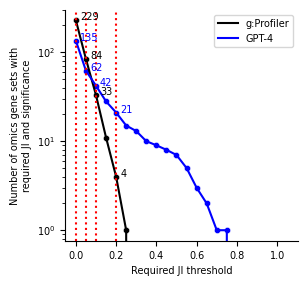

In [56]:
save_plot_dir = 'figures/omics_revamped_LLM_gprofiler_new_gene_name_DF_reduce_APV_add_JI_thresh_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_only_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05, 0.1, 0.2],figsize=(3,3), ax_label_keyword= 'JI', log_scale=True, save_file=save_plot_dir)

coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 163.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 69.0, LLM: 64.0


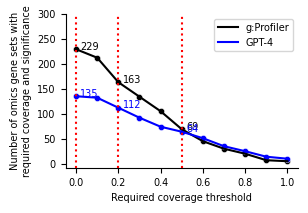

In [111]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'figures/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_only_DF, 'gprofiler_coverage', 'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.2, 0.5])

In [110]:
# save 
reduced_LLM_genes_APV_only_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only.tsv", sep="\t", index=False)

# 2.1 Best APV with highest coverage

 - Select the best GO term by the smallest p-value
 -- If there are multiple GO terms with the same smallest p-value, then select the term with the highest coverage.
 - Filter by both the p-value and coverage thresholds. 


In [51]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

coverage_thresh = 0.2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_cover_thresh_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_coverage')).reset_index(drop=True)


# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_cover_thresh_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_APV_cover_thresh_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_cover_thresh_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_coverage'] < coverage_thresh)) # enrichment criteria


print(create_success_contingency_table(reduced_LLM_genes_APV_cover_thresh_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_cover_thresh_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    96     91    187
False                   16     97    113
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,response to stress,GO:0006950,0.001123,22,3855,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,EXT1,NI...",0.500000,0.13,0.005674,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,developmental process,GO:0032502,0.005933,32,6453,"ABAT,ASS1,CHI3L1,CLDN3,FRZB,GAL,MAN2A1,NELL2,T...",0.603774,NaN,0.004943,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 187.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 86.0, LLM: 64.0


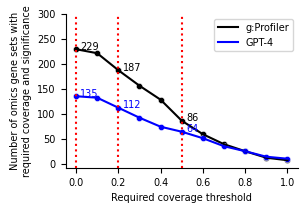

In [12]:
# plot
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_cover_thresh_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_cover_thresh_DF, 'gprofiler_coverage', 'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.2, 0.5])

In [15]:
# # save the file
# reduced_LLM_genes_APV_cover_thresh_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02.tsv", sep="\t", index=False)
# # save the T/F, F/T and T/T separately
# reduced_LLM_genes_APV_cover_thresh_DF[(reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] == True) & (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] == False)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmT_goF.tsv", sep="\t", index=False)
# reduced_LLM_genes_APV_cover_thresh_DF[(reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] == False) & (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmF_goT.tsv", sep="\t", index=False)

# # Calculated semantic similarity between LLM and gprofiler gene names by running "run_omics_sem_sim.py"
# # load the file with semantic similarity 
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_simVals_DF.tsv", sep="\t")
# #sort 
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF[(sim_val_reduce_LLM_gnees_APV_cover_thresh_DF['LLM_success_TF'] == True) & (sim_val_reduce_LLM_gnees_APV_cover_thresh_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmT_goT.tsv", sep="\t", index=False)

# 2.2 Best APV with highest JI
 - Select the best GO term by the smallest p-value
 -  If there are multiple GO terms with the same smallest p-value, then pick the term with the highest JI.
 - Filter by both the p-value and JI thresholds.


In [16]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

JI_thresh = 0.05
# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_thred_JI_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_JI')).reset_index(drop=True)


# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_thred_JI_DF ['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_APV_thred_JI_DF ['LLM_JI'] >= JI_thresh)) # LLM creteria
reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_thred_JI_DF ['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_APV_thred_JI_DF['gprofiler_JI'] < JI_thresh)) # enrichment criteria


print(create_success_contingency_table(reduced_LLM_genes_APV_thred_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_thred_JI_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    33     51     84
False                   29    187    216
Total                   62    238    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,False,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,inflammatory response,GO:0006954,0.001123,11,829,"1060P11.3,ADM,CAV2,CDC42EP3,EMP1,LPAR6,TRIB2,A...",0.250000,0.13,0.012761,False,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,actomyosin structure organization,GO:0031032,0.005933,6,204,"AKR1B1,CAPN3,DKK1,MARCKS,MTUS1,OPN3",0.113208,NaN,0.023904,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,False


                  True_True  True_False  False_True  False_False  Total
Input Source                                                           
L1000              7.936508   11.904762   15.079365    65.079365  100.0
NeST              18.253968   10.317460   23.809524    47.619048  100.0
Viral_Infections   0.000000    2.083333    4.166667    93.750000  100.0
Total             26.190476   24.305556   43.055556   206.448413  300.0


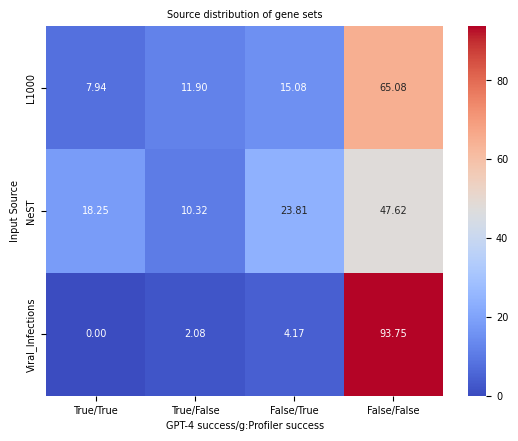

In [17]:
# I want to check for each cases T/T, T/F, F/T, F/F what is the distribution of sources of the gene sets
# Grouping the DataFrame by the specified columns
grouped_filter = reduced_LLM_genes_APV_thred_JI_DF.groupby(['LLM_success_TF', 'gprofiler_success_TF'])

# Apply the 'count Sources' to each group and reset the index
source_dist_DF = grouped_filter.apply(lambda x: x['Source'].value_counts()).reset_index(drop=False)
source_dist_DF.rename(columns={'Source':'Source distribution', 'level_2': 'Input Source'}, inplace=True)



# # create a contingency table
def create_source_dist_contingency_table(source_dist_DF):
    contingency_table = source_dist_DF.pivot(index='Input Source', columns=['LLM_success_TF', 'gprofiler_success_TF'], values='Source distribution').fillna(0)
    # reset column
    contingency_table = contingency_table[[(True, True), (True, False), (False, True), (False, False)]]
    # Reset the column names if desired
    contingency_table.columns = ['True_True', 'True_False', 'False_True', 'False_False']
    # normalize 
    contingency_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) *100
    # Add the total column and row
    contingency_table['Total'] = contingency_table.sum(axis=1)
    contingency_table.loc['Total'] = contingency_table.sum(axis=0)
    return contingency_table

source_dist_contingency_table = create_source_dist_contingency_table(source_dist_DF)
# Display the contingency table
print(source_dist_contingency_table )

def heatmap_source_dist(source_dist_DF):
    # Create a pivot table
    contingency_table = source_dist_DF.pivot(index='Input Source', columns=['LLM_success_TF', 'gprofiler_success_TF'], values='Source distribution').fillna(0)
    # reset column
    contingency_table = contingency_table[[(True, True), (True, False), (False, True), (False, False)]]
    # Reset the column names if desired
    contingency_table.columns = ['True/True', 'True/False', 'False/True', 'False/False']

    # normaliz by row
    contingency_table = (contingency_table.div(contingency_table.sum(axis=1), axis=0) *100)
    # Plot the heatmap
    sns.heatmap(contingency_table, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
    plt.title('Source distribution of gene sets')
    plt.xlabel('GPT-4 success/g:Profiler success')
    plt.show()

heatmap_source_dist(source_dist_DF)

coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 84.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 33.0, LLM: 42.0
coverage threshold: 0.2, enrichment: 4.0, LLM: 21.0


/cellar/users/mhu/Projects/llm_evaluation_for_gene_set_interpretation/utils/analyze_enrichment_utils.py:190: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  # plt.ylim(-8, 300)


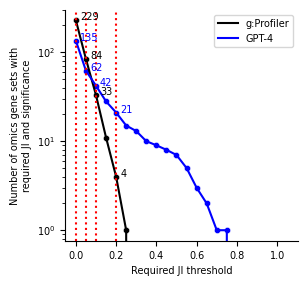

In [28]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'figures/omics_revamped_LLM_gprofiler_new_gene_name_DF_reduce_APV_add_JI_thresh_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_thred_JI_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05, 0.1, 0.2],figsize=(3,3), ax_label_keyword= 'JI', log_scale=True, save_file=save_plot_dir)

In [10]:
# # uncomment and save 
# reduced_LLM_genes_APV_thred_JI_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005.tsv", sep="\t", index=False)


# ### Calculated semantic similarity between LLM and gprofiler gene names by running "run_omics_sem_sim.py"
# sim_val_reduced_LLM_genes_APV_thred_JI_DF = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_simVals_DF.tsv", delimiter="\t")
# # # save the T/F, F/T and T/T separately
# sim_val_reduced_LLM_genes_APV_thred_JI_DF[(sim_val_reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == True) & (sim_val_reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == False)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmT_goF.tsv", sep="\t", index=False)
# sim_val_reduced_LLM_genes_APV_thred_JI_DF[(sim_val_reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == False) & (sim_val_reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmF_goT.tsv", sep="\t", index=False)
# sim_val_reduced_LLM_genes_APV_thred_JI_DF.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)
# sim_val_reduced_LLM_genes_APV_thred_JI_DF[(sim_val_reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == True) & (sim_val_reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmT_goT.tsv", sep="\t", index=False)


# 3.  Best coverage of those passing the p-value and coverage thresholds
 - Select the best GO term by highest coverage among the terms passing the p-value and coverage thresholds
 - Filter by both p-value and coverage thresholds to determine success vs not.

*Yields the SAME numbers as option #1 but selects different GO terms (prioritize coverage)*


In [34]:
from utils.analyze_enrichment_utils import filter_and_select_max_coverage
%reload_ext autoreload
%autoreload 2

grouped = merged_genes_DF.groupby(group_col)
reduced_LLM_genes_by_max_coverage_DF = grouped.apply(lambda x:filter_and_select_max_coverage(x, adj_pval_thresh, thresh=coverage_thresh)).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_max_coverage_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_max_coverage_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_by_max_coverage_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_by_max_coverage_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_max_coverage_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_max_coverage_DF['gprofiler_coverage'] < coverage_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_max_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_max_coverage_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   103    113    216
False                    9     75     84
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,biological regulation,GO:0065007,0.029217,20,12680,"CITED2,COL5A1,CRABP2,KCTD12,MDFIC,MMP2,NRP1,OR...",0.909091,0.21,0.001577,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,biological regulation,GO:0065007,0.034641,36,12680,"1060P11.3,ADM,AHR,ARL4C,ATP10D,CAV2,CD44,CHST1...",0.818182,0.13,0.002837,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to stimulus,GO:0050896,0.007235,38,8976,"ABAT,ASS1,CHI3L1,CHST2,CLDN3,FRZB,GAL,PDE8B,TB...",0.716981,NaN,0.004226,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of cellular process,GO:0050794,0.043562,9,11738,"AMIGO2,AREG,GAS6,GPR37,IFT57,PELI1,SQLE,AKAP12...",1.000000,NaN,0.000767,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,regulation of biological process,GO:0050789,0.018778,14,12287,"1060P11.3,CPE,EFNB2,H2AC6,IL1R2,INHBB,LYPD1,NU...",1.000000,NaN,0.001139,False,True


# 4. Best APV of those meeting both JI and apv threshold
 - Select the best GO term by the smallest p-value among the terms passing p-value and JI thresholds
 - Filter by both the p-value and JI thresholds to determine success vs not.


In [7]:
from utils.analyze_enrichment_utils import filter_and_select_coverage
%reload_ext autoreload
%autoreload

JI_thresh = 0.1
grouped = merged_genes_DF.groupby(group_col)
# Grouping the DataFrame by the specified columns
reduced_LLM_genes_by_apv_JI_DF = grouped.apply(lambda x: filter_and_select_coverage(x, adj_pval_thresh, 'gprofiler_JI', thresh=JI_thresh)).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'enrichr_success_TF' columns
reduced_LLM_genes_by_apv_JI_DF['LLM_success_TF'] = (reduced_LLM_genes_by_apv_JI_DF['Score'] >= LLM_score_thresh) & (reduced_LLM_genes_by_apv_JI_DF['LLM_JI'] >= JI_thresh) # LLM creteria
reduced_LLM_genes_by_apv_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_apv_JI_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_apv_JI_DF['gprofiler_JI'] < JI_thresh))

print(create_success_contingency_table(reduced_LLM_genes_by_apv_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_apv_JI_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    22     45     67
False                   20    213    233
Total                   42    258    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,False,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,False,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,False


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 97.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 67.0, LLM: 42.0


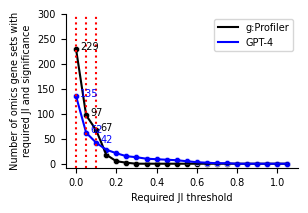

In [15]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_JI_curve.svg'
plot_thresholding_res(reduced_LLM_genes_by_apv_JI_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05, 0.1], ax_label_keyword='JI')

# 5. Best JI of those meeting both JI and apv threshold
- Select the best GO term by the highest JI among the terms passing both the p-value and JI thresholds
 - Filter by both the p-value and JI thresholds to determine success vs not.

Yields the SAME numbers as option #4, but selects different GO terms 


In [118]:
from utils.analyze_enrichment_utils import filter_and_select_max_coverage
%reload_ext autoreload
%autoreload 2

grouped = merged_genes_DF.groupby(group_col)
reduced_LLM_genes_by_max_JI_DF = grouped.apply(lambda x:filter_and_select_max_coverage(x, adj_pval_thresh, 'gprofiler_JI', thresh=JI_thresh)).reset_index(drop=True)

# # Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
# reduced_LLM_genes_by_max_JI_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_max_JI_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_by_max_JI_DF['LLM_JI'] >= JI_thresh)) # LLM creteria

# reduced_LLM_genes_by_max_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_max_JI_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_max_JI_DF['gprofiler_JI'] < JI_thresh)) # enrichment criteria

reduced_LLM_genes_by_max_JI_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_max_JI_DF['Score'] >= LLM_score_thresh)) # LLM creteria

reduced_LLM_genes_by_max_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_max_JI_DF['Adjusted P-value'] > adj_pval_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_max_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_max_JI_DF, 5)

result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   124    105    229
False                   11     60     71
Total                  135    165    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,regulation of peroxisome proliferator activate...,GO:0035358,0.010811,2,14,"CITED2,TWIST1",0.090909,0.21,0.058824,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,inflammatory response,GO:0006954,0.001123,11,829,"1060P11.3,ADM,CAV2,CDC42EP3,EMP1,LPAR6,TRIB2,A...",0.250000,0.13,0.012761,True,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,actomyosin structure organization,GO:0031032,0.005933,6,204,"AKR1B1,CAPN3,DKK1,MARCKS,MTUS1,OPN3",0.113208,NaN,0.023904,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to thyroid hormone stimulus,GO:0097067,0.004688,2,12,"IL1R2,CDH3",0.142857,NaN,0.083333,False,True


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 157.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 67.0, LLM: 42.0
coverage threshold: 0.2, enrichment: 9.0, LLM: 21.0
coverage threshold: 0.3, enrichment: 1.0, LLM: 13.0


/cellar/users/mhu/Projects/llm_evaluation_for_gene_set_interpretation/utils/analyze_enrichment_utils.py:190: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-8, 300)


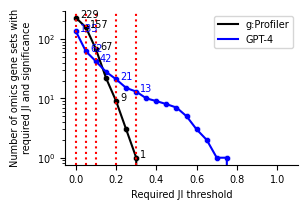

In [125]:
#plot
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'figures/omics_revamped_LLM_gprofiler_new_gene_name_DF_max_JI_curve.svg'
plot_thresholding_res(reduced_LLM_genes_by_max_JI_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05, 0.1, 0.2, 0.3], ax_label_keyword='JI', log_scale=True)

In [120]:
# save 
reduced_LLM_genes_by_max_JI_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_max_JI_significant.tsv", sep="\t", index=False)

## Computing semantic similarity of GO term name and LLM name when both methods yield a name using run_omics_sem_sim.py

In [37]:
# load the semantic similarity
# similarity_df = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_simVals_DF.tsv", sep="\t")  
similarity_df = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_simVals_DF.tsv", sep="\t")
# similarity_df = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_max_JI_significant_simVals_DF.tsv", sep="\t")
print(similarity_df.shape)
similarity_df.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)
similarity_df.head(5)

(300, 31)


,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,...,GenesMentionedInText,LLM_coverage,LLM_best_matching_GO,best_matching_GO_ID,best_matching_GO_term_genes,best_matching_GO_term_size,LLM_JI,LLM_success_TF,gprofiler_success_TF,LLM_name_GO_term_sim
56,NeST,Cluster1-21,Cluster1-21,AURKA CKAP5 TACC1 TACC2 YEATS4,AURKA CKAP5 TACC1 TACC2 YEATS4,5,Mitotic Spindle Assembly and Chromosome Segreg...,"1. AURKA, Aurora kinase A, is a serine/threoni...",0.92,mitotic spindle organization,...,5.0,0.80,mitotic spindle assembly,GO:0090307,MISP EML3 CEP192 ZNF207 RACGAP1 CHMP6 FLNA CHM...,73.0,0.051282,True,True,0.875087
82,NeST,Cluster2-134,Cluster2-134,ABHD13 APLF APTX ATP23 CETN2 CHD1L EHF GADD45G...,ABHD13 APLF APTX ATP23 CETN2 CHD1L EHF GADD45G...,23,DNA Damage Response and Repair,"1. The proteins ABHD13, APLF, APTX, CHD1L, GAD...",0.92,DNA repair,...,21.0,0.43,DNA damage response,GO:0006974,MAEL PMS2 ALKBH8 TAF6L MACROD1 TWIST1 NFATC2 C...,879.0,0.011261,True,True,0.833955
107,NeST,Cluster2-173,Cluster2-173,ACAA1 ACOX1 C6orf226 CAT DDO DECR2 HSD17B4 PEX...,ACAA1 ACOX1 C6orf226 CAT DDO DECR2 HSD17B4 PEX...,13,Peroxisomal Biogenesis and Function,1. ACAA1 (Acetyl-CoA acyltransferase 1) and AC...,0.94,peroxisome organization,...,13.0,0.69,peroxisome membrane biogenesis,GO:0016557,PEX16 PEX11A,2.0,0.642857,True,True,0.817934
73,NeST,Cluster2-118,Cluster2-118,MAGEL2 SNX5 SNX6 SNX7 WASHC3 WDFY1,MAGEL2 SNX5 SNX6 SNX7 WASHC3 WDFY1,6,Endosomal Sorting and Trafficking,1. MAGEL2 is a member of the MAGE family and i...,0.91,endosomal transport,...,6.0,1.00,endosomal transport,GO:0016197,PICALM HOOK1 EPS15 ANXA8L1 MYO5B STX8 VPS11 CH...,289.0,0.020690,True,True,0.815202
77,NeST,Cluster2-123,Cluster2-123,LYST NRDE2 REN SNRPA1 SNX6 SNX7 SNX12 SORT1 TM...,LYST NRDE2 REN SNRPA1 SNX6 SNX7 SNX12 SORT1 TM...,13,Endosomal Sorting and Trafficking,"1. LYST, or lysosomal trafficking regulator, i...",0.85,endosomal transport,...,13.0,0.54,endosomal transport,GO:0016197,PICALM HOOK1 EPS15 ANXA8L1 MYO5B STX8 VPS11 CH...,289.0,0.023649,True,True,0.815202


(124, 31)


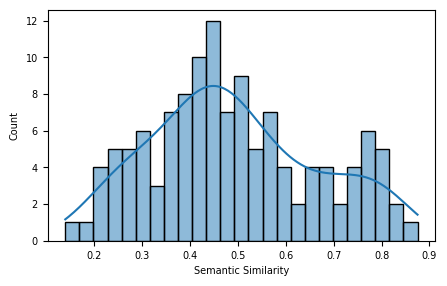

In [38]:
both_success = similarity_df[(similarity_df['LLM_success_TF'] == True) & (similarity_df['gprofiler_success_TF'] == True)]
print(both_success.shape)
# plot distribution of the similarity
plt.figure(figsize=(5,3))
sns.histplot(data=both_success, x='LLM_name_GO_term_sim', bins=25, kde=True)
plt.xlabel('Semantic Similarity')
plt.ylabel('Count')
plt.show()

In [39]:
# print the sources for both success
print(both_success['Source'].value_counts())

NeST                74
L1000               45
Viral_Infections     5
Name: Source, dtype: int64


## Select the tails of the distribution

In [40]:
# cases above vs below the threshold
similarity_thre = 0.5
print(both_success[both_success['LLM_name_GO_term_sim'] > similarity_thre].shape[0])
print(both_success[both_success['LLM_name_GO_term_sim'] <= similarity_thre].shape[0])

53
71


In [41]:
# any GO term with JI threshold >0.2?
similarity_df.loc[similarity_df['gprofiler_JI'] > 0.2,['n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID','LLM_name_GO_term_sim',
        'Adjusted P-value', 'intersection_size', 'term_size', 'intersections',  'gprofiler_coverage','LLM_coverage', 'gprofiler_JI', 'LLM_JI',
        'LLM_success_TF', 'gprofiler_success_TF']]


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,LLM_name_GO_term_sim,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_JI,LLM_success_TF,gprofiler_success_TF
123,8,FBXO45 HEY1 HEY2 HEYL NINL PAWR SPRYD3 THAP1,Regulation of transcription and cell signaling...,0.88,umbilical cord morphogenesis,GO:0036304,0.365624,0.000010,2,2,"HEY1,HEY2",0.285714,0.75,0.285714,0.002478,True,True
136,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,NaN,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,NaN,False,True


## Compare p:Profiler coverage vs LLM coverage and show semantic similarity

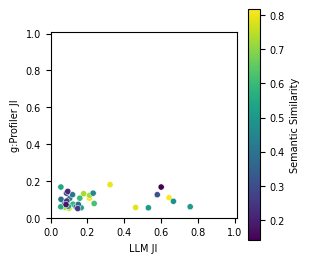

In [52]:
# LLM coverage vs gprofiler converage, colored by the similarity with countinuous color
plt.figure(figsize=(3,3))

y_field = 'gprofiler_JI'
y_label = 'g:Profiler JI'
x_field = 'LLM_JI'
x_label = 'LLM JI'


ax = sns.scatterplot(data=both_success, x=x_field, y=y_field, hue='LLM_name_GO_term_sim', palette='viridis',s = 20,legend=None)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xlim(0,1.01)
plt.ylim(0,1.01)

# # Setting the aspect of the plot to be equal
ax.set_aspect('equal', adjustable='box')

# Create a colorbar
norm = plt.Normalize(both_success['LLM_name_GO_term_sim'].min(), both_success['LLM_name_GO_term_sim'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, label='Semantic Similarity')

plt.show()



## Compare p:Profiler JI vs LLM JI and show semantic similarity

high similarity:  53
low similarity:  71


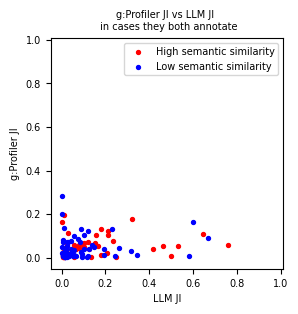

In [42]:
# Define the semantic similarity threshold you're interested in splitting the data
similarity_thre = 0.5

y_field = 'gprofiler_JI'
y_label = 'g:Profiler JI'
x_field = 'LLM_JI'
x_label = 'LLM JI'

# y_field = 'gprofiler_coverage'
# y_label = 'g:Profiler coverage'
# x_field = 'LLM_coverage'
# x_label = 'LLM coverage'

# Filter the DataFrame
filtered_data_high = both_success[both_success['LLM_name_GO_term_sim'] >= similarity_thre]
filtered_data_low = both_success[both_success['LLM_name_GO_term_sim'] < similarity_thre]

print('high similarity: ', len(filtered_data_high))
print('low similarity: ', len(filtered_data_low))
# LLM JI vs gprofiler JI, colored by the similarity with countinuous color
plt.figure(figsize=(3,3))

# Create the scatter plot using the filtered data with explicit normalization
# Here, we switch to using matplotlib directly
sc = plt.scatter(
    x=filtered_data_high[x_field], 
    y=filtered_data_high[y_field], 
    c='red',
    s=8,  # Set the size of the points
    label='High semantic similarity'
)
# plot the low similarity data
plt.scatter(
    x=filtered_data_low[x_field], 
    y=filtered_data_low[y_field], 
    c='blue',
    s=8,  # Set the size of the points
    label='Low semantic similarity'
)
plt.title('g:Profiler JI vs LLM JI \n in cases they both annotate')
plt.xlabel(x_label)
plt.ylabel(y_label)
# plt.axvline(x=JI_thresh, color='black', linestyle='--', label='JI threshold')
# plt.axhline(y=JI_thresh, color='black', linestyle='--')
plt.xlim(-0.05, 1.01)
plt.ylim(-0.05, 1.01)

plt.legend()

plt.show()

In [45]:
#number of times high similarity is llm JI bigger than gprofiler JI
print(sum(filtered_data_high[x_field] > filtered_data_high[y_field]))
print (sum(filtered_data_high[x_field] > filtered_data_high[y_field])/len(filtered_data_high))

38
0.7169811320754716


high similarity: 54
low similarity: 81
Spearman's rank correlation (high similarity): 0.3750405001729387
 p-value: 0.005201644931525039
Spearman's rank correlation (low similarity): 0.054056190488316384 
 p-value: 0.6317289712519722
0.20544637967920237
0.1213240704255618


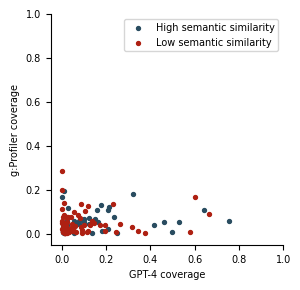

In [16]:
from scipy.stats import spearmanr, kendalltau
LLM_annotated = similarity_df[(similarity_df['LLM_success_TF'] == True)]


similarity_thre = 0.5

y_field = 'gprofiler_JI'
y_label = 'g:Profiler coverage'
x_field = 'LLM_JI'
x_label = 'GPT-4 coverage'

# y_field = 'gprofiler_coverage'
# y_label = 'g:Profiler coverage'
# x_field = 'LLM_coverage'
# x_label = 'LLM coverage'

# Filter the DataFrame
filtered_data_high = LLM_annotated[LLM_annotated['LLM_name_GO_term_sim'] >= similarity_thre]
filtered_data_low = LLM_annotated[LLM_annotated['LLM_name_GO_term_sim'] < similarity_thre]
print(f'high similarity: {filtered_data_high.shape[0]}')
print(f'low similarity: {filtered_data_low.shape[0]}')


# Calculate Spearman's rank correlation
spearman_corr_high, p_high = spearmanr(filtered_data_high[x_field], filtered_data_high[y_field])
spearman_corr_low, p_low = spearmanr(filtered_data_low[x_field], filtered_data_low[y_field])


print(f"Spearman's rank correlation (high similarity): {spearman_corr_high}\n p-value: {p_high}")
print(f"Spearman's rank correlation (low similarity): {spearman_corr_low} \n p-value: {p_low}")

# LLM JI vs gprofiler JI, colored by the similarity with countinuous color
plt.figure(figsize=(3,3))

# Create the scatter plot using the filtered data with explicit normalization
# Here, we switch to using matplotlib directly
plt.scatter(
    x=filtered_data_high[x_field], 
    y=filtered_data_high[y_field], 
    c='#294c60',
    s=8,  # Set the size of the points
    label='High semantic similarity'
)

# calculate the correlation
print(filtered_data_high[x_field].corr(filtered_data_high[y_field]))

# plot the low similarity data
plt.scatter(
    x=filtered_data_low[x_field], 
    y=filtered_data_low[y_field], 
    c='#ae2012',
    s=8,  # Set the size of the points
    label='Low semantic similarity'
)
# Trend lines
# z_high = np.polyfit(filtered_data_high[x_field], filtered_data_high[y_field], 1)
# p_high = np.poly1d(z_high)
# plt.plot(filtered_data_high[x_field], p_high(filtered_data_high[x_field]), "#294c60", alpha=0.5)

# z_low = np.polyfit(filtered_data_low[x_field], filtered_data_low[y_field], 1)
# p_low = np.poly1d(z_low)
# plt.plot(filtered_data_low[x_field], p_low(filtered_data_low[x_field]), "#ae2012", alpha=0.5)

# calculate the correlation
print(filtered_data_low[x_field].corr(filtered_data_low[y_field]))

# annotate specific points
# for i, (llm_txt, go_txt) in enumerate(zip(filtered_data_low['LLM Name'], filtered_data_low['Term'])):
#     if filtered_data_low.iloc[i]['LLM_JI'] > 0.5:
#         plt.annotate(llm_txt, (filtered_data_low[x_field].iloc[i]+0.02, filtered_data_low[y_field].iloc[i]), fontsize=5)
        # plt.annotate(go_txt, (filtered_data_low[x_field].iloc[i], filtered_data_low[y_field].iloc[i]-0.05), fontsize=5)
# plt.title('g:Profiler JI vs LLM JI \n in cases they both annotate')
plt.xlabel(x_label)
plt.ylabel(y_label)
# plt.axvline(x=JI_thresh, color='black', linestyle='--', label='JI threshold')
# plt.axhline(y=JI_thresh, color='black', linestyle='--')
plt.xlim(-0.05, 1)
plt.ylim(-0.05, 1)
sns.despine()
plt.legend()
# plt.savefig('figures/omics_LLM_JI_vs_gprofiler_JI_sep_by_similarity.svg', dpi=300)
plt.show()

In [19]:
LLM_annotated.loc[LLM_annotated['LLM_JI'] > LLM_annotated['gprofiler_JI'],['n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID','LLM_name_GO_term_sim','LLM_JI','gprofiler_JI']]

,n_Genes,GeneList,LLM Name,Score,Term,GO ID,LLM_name_GO_term_sim,LLM_JI,gprofiler_JI
56,5,AURKA CKAP5 TACC1 TACC2 YEATS4,Mitotic Spindle Assembly and Chromosome Segreg...,0.92,mitotic spindle organization,GO:0007052,0.875087,0.051282,0.029851
107,13,ACAA1 ACOX1 C6orf226 CAT DDO DECR2 HSD17B4 PEX...,Peroxisomal Biogenesis and Function,0.94,peroxisome organization,GO:0007031,0.817934,0.642857,0.108696
73,6,MAGEL2 SNX5 SNX6 SNX7 WASHC3 WDFY1,Endosomal Sorting and Trafficking,0.91,endosomal transport,GO:0016197,0.815202,0.020690,0.017422
77,13,LYST NRDE2 REN SNRPA1 SNX6 SNX7 SNX12 SORT1 TM...,Endosomal Sorting and Trafficking,0.85,endosomal transport,GO:0016197,0.815202,0.023649,0.020548
59,93,ANKRD45 BBOF1 C1orf194 C2orf73 C11orf63 C11orf...,Ciliogenesis and Ciliary Function,0.92,cilium movement,GO:0003341,0.805732,0.210526,0.106557
...,...,...,...,...,...,...,...,...,...
120,21,ATXN3 CCNA2 CHEK2 COPS5 CREBBP CTNNB1 EP300 HD...,Chromatin remodeling and transcriptional regul...,0.92,positive regulation of RNA biosynthetic process,GO:1902680,0.227990,0.022901,0.009942
121,21,AR CARM1 COPS2 CREBBP E2F1 EP300 HDAC2 HDAC3 H...,Chromatin remodeling and transcriptional regul...,0.92,negative regulation of nucleobase-containing c...,GO:0045934,0.210030,0.021374,0.010050
54,7,AK2 CDH1 HADHA HADHB MT-ATP8 MT-ND4L SQSTM1,Mitochondrial Energy Metabolism and Cellular A...,0.85,ribonucleotide biosynthetic process,GO:0009260,0.203701,0.057143,0.012766
26,29,1060P11.3 AEBP1 AMIGO2 CNPY3 FABP7 HMGCR HMGCS...,Cholesterol Biosynthesis and Regulation,0.85,positive regulation of aggrephagy,GO:1905337,0.179547,0.083333,0.071429


In [15]:
# find number of clusters similar in name but higher llm JI 
len(filtered_data_high.loc[filtered_data_high['LLM_JI'] > filtered_data_high['gprofiler_JI'], ['n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID','LLM_name_GO_term_sim','LLM_JI','gprofiler_JI']])

38

In [133]:
similarity_df.columns

Index(['Source', 'GeneSetID', 'GeneSetName', 'GeneList', 'updated GeneList',
       'n_Genes', 'LLM Name', 'LLM Analysis', 'Score', 'Term', 'GO ID',
       'Adjusted P-value', 'intersection_size', 'term_size', 'query_size',
       'intersections', 'gprofiler_JI', 'gprofiler_coverage',
       'Supporting Genes', 'Supporting Count', 'LLM Support Analysis',
       'GenesMentionedInText', 'LLM_coverage', 'LLM_best_matching_GO',
       'best_matching_GO_ID', 'best_matching_GO_term_genes',
       'best_matching_GO_term_size', 'LLM_JI', 'LLM_success_TF',
       'gprofiler_success_TF', 'LLM_name_GO_term_sim'],
      dtype='object')

In [28]:

filter = merged_genes_DF.loc[
(merged_genes_DF['GeneSetID'] == 'Cluster2-105') & (merged_genes_DF['Adjusted P-value'] <= 0.05), ['n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID','Adjusted P-value', 'LLM_name_GO_term_sim','LLM_JI','gprofiler_JI']].sort_values(by='LLM_name_GO_term_sim', ascending=False).reset_index(drop=True)
filter


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,LLM_name_GO_term_sim,LLM_JI,gprofiler_JI
0,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,regulation of ribonucleoprotein complex locali...,GO:2000197,0.045481,0.541379,0.6,0.041667
1,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,ribonucleoprotein complex localization,GO:0071166,0.048238,0.477766,0.6,0.040000
2,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,regulation of metal ion transport,GO:0010959,0.002892,0.472817,0.6,0.010499
3,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,protein complex oligomerization,GO:0051259,0.012072,0.427468,0.6,0.010830
4,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,regulation of transport,GO:0051049,0.038352,0.419190,0.6,0.003115
...,...,...,...,...,...,...,...,...,...,...
128,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,positive regulation of sodium ion transport,GO:0010765,0.004288,0.143188,0.6,0.045455
129,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,negative regulation of pancreatic juice secretion,GO:0090188,0.000003,0.140170,0.6,0.166667
130,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,sodium ion transmembrane transport,GO:0035725,0.000255,0.137953,0.6,0.022472
131,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,positive regulation of sodium ion transmembran...,GO:1902307,0.001723,0.126477,0.6,0.064516


In [32]:
filter.loc[filter['Term'] == 'protein ubiquitination']

,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,LLM_name_GO_term_sim,LLM_JI,gprofiler_JI
23,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,protein ubiquitination,GO:0016567,0.000009,0.337778,0.6,0.01023


In [31]:
filter['Term'].iloc[:20]

0     regulation of ribonucleoprotein complex locali...
1                ribonucleoprotein complex localization
2                     regulation of metal ion transport
3                       protein complex oligomerization
4                               regulation of transport
5                intracellular chloride ion homeostasis
6                              chloride ion homeostasis
7                          regulation of system process
8             organonitrogen compound metabolic process
9     regulation of protein localization to cell per...
10                regulation of transmembrane transport
11    regulation of monoatomic cation transmembrane ...
12                                 renal system process
13                                 chemical homeostasis
14                        monoatomic cation homeostasis
15                proteasomal protein catabolic process
16                              cell volume homeostasis
17                      regulation of body fluid

In [129]:
similarity_df.loc[similarity_df['GeneSetID'] == 'Cluster2-105', ['GeneList', 'LLM Name', 'Score', 'Term', 'GO ID','LLM_name_GO_term_sim']]

,GeneList,LLM Name,Score,Term,GO ID,LLM_name_GO_term_sim
66,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,negative regulation of pancreatic juice secretion,GO:0090188,0.14017


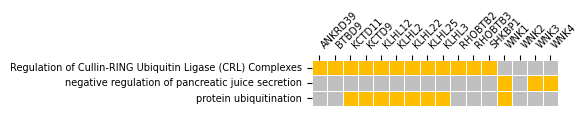

In [18]:
# find the GeneSetID: Cluster2-105 from the full table
example = merged_genes_DF.loc[
merged_genes_DF['GeneSetID'] == 'Cluster2-105'].iloc[[0,2]] # one is the most significant, one is more similar name
# example
geneList = example['GeneList'].values[0].split(' ')

new_cols = ['Name', 'Supporting Genes','Named by']
new_df = pd.DataFrame(columns=new_cols)

# LLM supporting genes
llm_supporting_genes = example['Supporting Genes'].values[0].split(' ')
# Join the LLM supporting genes list into a single string
llm_supporting_genes_str = ', '.join(llm_supporting_genes)
llm_name_row = pd.DataFrame({'Name': [example['LLM Name'].values[0]], 'Supporting Genes': llm_supporting_genes_str, 'Named by': ['GPT-4']})
new_df = pd.concat([new_df, llm_name_row], ignore_index=True)

for go_term in example['Term'].values:
    intersection = example.loc[example['Term'] == go_term, 'intersections'].values[0].split(',')
    # Join the intersection list into a single string
    intersection_str = ', '.join(intersection)
    new_row = pd.DataFrame({'Name': [go_term], 'Supporting Genes': intersection_str, 'Named by': ['g:Profiler']})
    new_df = pd.concat([new_df, new_row], ignore_index=True)


new_df = new_df.reset_index(drop=True)
# new_df
# geneList
# plot a heatmap, where columns are the genes and rows are the gene sets, heat at the intersections

# column is all the genes in the target gene set 
genes = set(geneList)
genes = sorted(genes)

# Create a binary matrix
matrix = pd.DataFrame(0, index=new_df['Name'], columns=genes)
for idx, row in new_df.iterrows():
    supporting_genes = row['Supporting Genes'].split(', ')
    matrix.loc[row['Name'], supporting_genes] = 1

# Calculate appropriate figure size based on the number of genes and gene sets
fig_height =len(new_df['Name']) * 0.2
fig_width= len(genes) * 0.2

# Plot the heatmap with square cells and adjusted figure size
plt.figure(figsize=(fig_width, fig_height))
ax = sns.heatmap(matrix, cmap=['#c0c0c0', '#ffbd00'], cbar=False, linewidths=.5, annot=False, square=True)
# Move the x-axis labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Adjust the font size of the labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')


plt.xlabel('')
plt.ylabel('')
plt.savefig('figures/omics_LLM_gprofiler_CULLIN_example_gene_intersection_heatmap.svg', dpi=300)
plt.show()